In [1]:
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
import torch.nn.functional as F
import wandb
import os
import time
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import math
import torch

In [2]:
# Definir la arquitectura de la CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        #Canales de entrada, Canales de salida, Tamaño de Kernel, Stride y Padding
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 2)
        self.conv2 = nn.Conv2d(16, 64, 3, 1, 1) 
        self.conv3 = nn.Conv2d(64, 128, 3, 1, 1)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(128 * 16 * 16, 512) 
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 3)

    def forward(self, x):
        #Entrada (batch, channels, ancho, largo)
        # (64, 3, 32, 32)
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2, 2) # No es una capa aprendible. (feature_maps, stride, padding)
        # (64, 16, 16, 16)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2, 2)
        # (64, 64, 8, 8)
        x = torch.relu(self.conv3(x))
        x = self.dropout(x)
        x = torch.max_pool2d(x, 2, 2)
        # (64, 128, 4, 4)
        x = x.view(-1, 128 * 16 * 16)
        # (64, 2048)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
# Definir la arquitectura de la CNN 1 convoluciones y 1 redes fc 
# Definir la arquitectura de la CNN
class CNNSimpleUno(nn.Module):
    def __init__(self):
        super(CNNSimpleUno, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, 3,1,2)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 3)

    def forward(self, x):

        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 8, 8)

        x = self.dropout(x)

        x = x.view(-1, 128 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    # Definir la arquitectura de la CNN 2 convoluciones y 2 redes fc 
class CNNSimpleDos(nn.Module):
    def __init__(self):
        super(CNNSimpleDos, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3,1,2)
        self.conv2 = nn.Conv2d(64, 128, 3, 1, 1) 

        self.dropout = nn.Dropout(0.2)

        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 3)

    def forward(self, x):

        x = torch.relu(self.conv1(x))

        x = torch.max_pool2d(x, 4, 4)
       

        x = torch.relu(self.conv2(x))
        x = self.dropout(x)
        x = torch.max_pool2d(x, 2, 2)
        x = x.view(-1, 128 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
  

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Is Torch Cuda Available? " + str(torch.cuda.is_available()))

Is Torch Cuda Available? True


In [5]:
def train(network,  criterion, optimizer, trainloader):
    network.train() # Se asigna el the modelo a train mode
    running_loss = 0.0
    #correctos y torales para el acurracy
    correct = 0
    total = 0
    # Entrenamiento del modelo
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = network(inputs)
        # Se calcula el loss actual 
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
         #Para el accuracy
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        
        correct += predicted.eq(labels).sum().item()
    accuracy = 100 * correct / total
    return running_loss / len(trainloader), accuracy

def validate(network,  criterion, testloader):
    network.eval()  # Se asigna el the modelo a evaluation mode
    total_loss = 0.0
    #correctos y torales para el acurracy
    correct = 0
    total = 0
    # Y correctos y la Y predicion matrix de confusion
    y_true = []
    y_pred = []
    # Testeo del modelo
    with torch.no_grad():  # Disable gradient computation during validation
        for data in testloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = network(inputs)
            loss = criterion(outputs, labels)
            # Se calcula el loss actual 
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            #Para el accuracy
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            #matrix de confusion
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    
    accuracy = 100 * correct / total
    avg_loss = total_loss / len(testloader)
    return avg_loss, accuracy,y_true,y_pred

In [ ]:
# CNNSimpleDos con raw dataset
# directorio para leer los datos
data_dir = 'C:/Users/tian_/Desktop/Proyecto2/Data/raw'

transform = transforms.Compose([
    # convert the images to tensor shape
    transforms.ToTensor(),
    # Transformrs the images to 128 x 128, se hace porque no son constantes los tamaños
    transforms.Resize((128, 128)),
    # se normalizan los canales RGB la media y la deviacion stander en 0.5 cada canal
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# Data Loader carga del folder de training las imagenes y las etiqueta con el nombre del folder donde estan
# en este caso Covid, Normal y Viral Pneumonia
trainset = datasets.ImageFolder(os.path.join(data_dir, 'training_set'), transform=transform)
testset = datasets.ImageFolder(os.path.join(data_dir, 'test_set'), transform=transform)
#Iterable del dataset
# probar con 32 or 64 for better results
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
#Iterable del dataset
testloader = DataLoader(testset, batch_size=32, shuffle=False)
# se encuenta el numero de ejemplos, el numero de batch preselecionado y se calculan el total de numero de batceh por epoca
total_samples = len(trainloader.dataset)
batch_size = trainloader.batch_size
num_batches_per_epoch = math.ceil(total_samples / batch_size)

print("Total samples:", total_samples)
print("Batch size:", batch_size)
print("Number of batches per epoch:", num_batches_per_epoch)

# Set your API key as an environment variable para wandb
os.environ["WANDB_API_KEY"] = "ea93e82127178cd6709c03f277029a17909d3cbc"
wandb.login()

# Hyperparametros de entrenamiento
epochs = 10
lr = 0.0005
class_names = ["Covid", "Normal", "Viral Pneumonia"]

# Parametros para inicializar Wandb
run = wandb.init(
    # Set the project where this run will be logged
    project="Proyecto2",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": epochs,
    },
)

#Se inicializa la red y se escoge la funcion de perdida y la de optimizacion
network = CNNSimpleDos().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), lr)

# Log the network weight histograms (optional)
wandb.watch(network, log="all")


start_time = time.time()
for epoch in range(1, epochs+1):
    
    loss_train, acc_train = train(network,  criterion, optimizer, trainloader)
    loss_valid, acc_valid,y_true,y_pred = validate(network,  criterion, testloader)
    
    print('Epoch: {}  Train Loss: {:.4f}  Train Acc: {:.4f}  Valid Loss: {:.4f}  Valid Acc: {:.4f}'.format(epoch, loss_train, acc_train, loss_valid, acc_valid))

    # Logs en tiempo real de wandb
    wandb.log({
        "Epoch": epoch,
        "Train Loss": loss_train,
        "Train Acc": acc_train,
        "Valid Loss": loss_valid,
        "Valid Acc": acc_valid,
        "Elapsed time:":time.time() - start_time})
    
    wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(probs=None,
                                                                y_true=y_true,
                                                                preds=y_pred,
                                                                class_names=class_names,
                                                                title = "Confusion Matrix")},
                                                                commit=False)
    
   






In [ ]:
# CNNSimpleDos con cannyfilter dataset
# directorio para leer los datos
data_dir = 'C:/Users/tian_/Desktop/Proyecto2/Data/cannyFilter'
transform = transforms.Compose([
    # convert the images to tensor shape
    transforms.ToTensor(),
    # Transformrs the images to 128 x 128, se hace porque no son constantes los tamaños
    transforms.Resize((32, 32)),
    # se normalizan los canales RGB la media y la deviacion stander en 0.5 cada canal
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# Data Loader carga del folder de training las imagenes y las etiqueta con el nombre del folder donde estan
# en este caso Covid, Normal y Viral Pneumonia
trainset = datasets.ImageFolder(os.path.join(data_dir, 'training_set'), transform=transform)
testset = datasets.ImageFolder(os.path.join(data_dir, 'test_set'), transform=transform)
#Iterable del dataset
# probar con 32 or 64 for better results
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
#Iterable del dataset
testloader = DataLoader(testset, batch_size=32, shuffle=False)
# se encuenta el numero de ejemplos, el numero de batch preselecionado y se calculan el total de numero de batceh por epoca
total_samples = len(trainloader.dataset)
batch_size = trainloader.batch_size
num_batches_per_epoch = math.ceil(total_samples / batch_size)

print("Total samples:", total_samples)
print("Batch size:", batch_size)
print("Number of batches per epoch:", num_batches_per_epoch)
# Set your API key as an environment variable para wandb
os.environ["WANDB_API_KEY"] = "ea93e82127178cd6709c03f277029a17909d3cbc"
wandb.login()

# Hyperparametros de entrenamiento
epochs = 10
lr = 0.0005
class_names = ["Covid", "Normal", "Viral Pneumonia"]

# Parametros para inicializar Wandb
run = wandb.init(
    # Set the project where this run will be logged
    project="Proyecto2",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": epochs,
    },
)

#Se inicializa la red y se escoge la funcion de perdida y la de optimizacion
network = CNNSimpleDos().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), lr)

# Log the network weight histograms (optional)
wandb.watch(network, log="all")


start_time = time.time()
for epoch in range(1, epochs+1):
    
    loss_train, acc_train = train(network,  criterion, optimizer, trainloader)
    loss_valid, acc_valid,y_true,y_pred = validate(network,  criterion, testloader)
    
    print('Epoch: {}  Train Loss: {:.4f}  Train Acc: {:.4f}  Valid Loss: {:.4f}  Valid Acc: {:.4f}'.format(epoch, loss_train, acc_train, loss_valid, acc_valid))

    # Logs en tiempo real de wandb
    wandb.log({
        "Epoch": epoch,
        "Train Loss": loss_train,
        "Train Acc": acc_train,
        "Valid Loss": loss_valid,
        "Valid Acc": acc_valid,
        "Elapsed time:":time.time() - start_time})
    
    wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(probs=None,
                                                                y_true=y_true,
                                                                preds=y_pred,
                                                                class_names=class_names,
                                                                title = "Confusion Matrix")},
                                                                commit=False)
    
   

In [ ]:
# CNNSimpleDos con bilateralFilter dataset
# directorio para leer los datos
data_dir = 'C:/Users/tian_/Desktop/Proyecto2/Data/bilateralFilter'
transform = transforms.Compose([
    # convert the images to tensor shape
    transforms.ToTensor(),
    # Transformrs the images to 128 x 128, se hace porque no son constantes los tamaños
    transforms.Resize((32, 32)),
    # se normalizan los canales RGB la media y la deviacion stander en 0.5 cada canal
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# Data Loader carga del folder de training las imagenes y las etiqueta con el nombre del folder donde estan
# en este caso Covid, Normal y Viral Pneumonia
trainset = datasets.ImageFolder(os.path.join(data_dir, 'training_set'), transform=transform)
testset = datasets.ImageFolder(os.path.join(data_dir, 'test_set'), transform=transform)
#Iterable del dataset
# probar con 32 or 64 for better results
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
#Iterable del dataset
testloader = DataLoader(testset, batch_size=32, shuffle=False)
# se encuenta el numero de ejemplos, el numero de batch preselecionado y se calculan el total de numero de batceh por epoca
total_samples = len(trainloader.dataset)
batch_size = trainloader.batch_size
num_batches_per_epoch = math.ceil(total_samples / batch_size)

print("Total samples:", total_samples)
print("Batch size:", batch_size)
print("Number of batches per epoch:", num_batches_per_epoch)
# Set your API key as an environment variable para wandb
os.environ["WANDB_API_KEY"] = "ea93e82127178cd6709c03f277029a17909d3cbc"
wandb.login()

# Hyperparametros de entrenamiento
epochs = 10
lr = 0.0005
class_names = ["Covid", "Normal", "Viral Pneumonia"]

# Parametros para inicializar Wandb
run = wandb.init(
    # Set the project where this run will be logged
    project="Proyecto2",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": epochs,
    },
)

#Se inicializa la red y se escoge la funcion de perdida y la de optimizacion
network = CNNSimpleDos().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), lr)

# Log the network weight histograms (optional)
wandb.watch(network, log="all")
start_time = time.time()
for epoch in range(1, epochs+1):
    
    loss_train, acc_train = train(network,  criterion, optimizer, trainloader)
    loss_valid, acc_valid,y_true,y_pred = validate(network,  criterion, testloader)
    
    print('Epoch: {}  Train Loss: {:.4f}  Train Acc: {:.4f}  Valid Loss: {:.4f}  Valid Acc: {:.4f}'.format(epoch, loss_train, acc_train, loss_valid, acc_valid))

    # Logs en tiempo real de wandb
    wandb.log({
        "Epoch": epoch,
        "Train Loss": loss_train,
        "Train Acc": acc_train,
        "Valid Loss": loss_valid,
        "Valid Acc": acc_valid,
        "Elapsed time:":time.time() - start_time})
    
    wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(probs=None,
                                                                y_true=y_true,
                                                                preds=y_pred,
                                                                class_names=class_names,
                                                                title = "Confusion Matrix")},
                                                                commit=False)

In [ ]:
# CNNSimpleUno con raw dataset
# directorio para leer los datos
data_dir = 'C:/Users/tian_/Desktop/Proyecto2/Data/raw'
transform = transforms.Compose([
    # convert the images to tensor shape
    transforms.ToTensor(),
    # Transformrs the images to 128 x 128, se hace porque no son constantes los tamaños
    transforms.Resize((32, 32)),
    # se normalizan los canales RGB la media y la deviacion stander en 0.5 cada canal
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# Data Loader carga del folder de training las imagenes y las etiqueta con el nombre del folder donde estan
# en este caso Covid, Normal y Viral Pneumonia
trainset = datasets.ImageFolder(os.path.join(data_dir, 'training_set'), transform=transform)
testset = datasets.ImageFolder(os.path.join(data_dir, 'test_set'), transform=transform)
#Iterable del dataset
# probar con 32 or 64 for better results
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
#Iterable del dataset
testloader = DataLoader(testset, batch_size=32, shuffle=False)
# se encuenta el numero de ejemplos, el numero de batch preselecionado y se calculan el total de numero de batceh por epoca
total_samples = len(trainloader.dataset)
batch_size = trainloader.batch_size
num_batches_per_epoch = math.ceil(total_samples / batch_size)

print("Total samples:", total_samples)
print("Batch size:", batch_size)
print("Number of batches per epoch:", num_batches_per_epoch)
# Set your API key as an environment variable para wandb
os.environ["WANDB_API_KEY"] = "ea93e82127178cd6709c03f277029a17909d3cbc"
wandb.login()

# Hyperparametros de entrenamiento
epochs = 10
lr = 0.0005
class_names = ["Covid", "Normal", "Viral Pneumonia"]

# Parametros para inicializar Wandb
run = wandb.init(
    # Set the project where this run will be logged
    project="Proyecto2",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": epochs,
    },
)

#Se inicializa la red y se escoge la funcion de perdida y la de optimizacion
network = CNNSimpleUno().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), lr)

# Log the network weight histograms (optional)
wandb.watch(network, log="all")
start_time = time.time()
for epoch in range(1, epochs+1):
    
    loss_train, acc_train = train(network,  criterion, optimizer, trainloader)
    loss_valid, acc_valid,y_true,y_pred = validate(network,  criterion, testloader)
    
    print('Epoch: {}  Train Loss: {:.4f}  Train Acc: {:.4f}  Valid Loss: {:.4f}  Valid Acc: {:.4f}'.format(epoch, loss_train, acc_train, loss_valid, acc_valid))

    # Logs en tiempo real de wandb
    wandb.log({
        "Epoch": epoch,
        "Train Loss": loss_train,
        "Train Acc": acc_train,
        "Valid Loss": loss_valid,
        "Valid Acc": acc_valid,
        "Elapsed time:":time.time() - start_time})
    
    wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(probs=None,
                                                                y_true=y_true,
                                                                preds=y_pred,
                                                                class_names=class_names,
                                                                title = "Confusion Matrix")},
                                                                commit=False)

In [ ]:
# CNNSimpleUno con cannyFilter dataset
# directorio para leer los datos
data_dir = 'C:/Users/tian_/Desktop/Proyecto2/Data/cannyFilter'
transform = transforms.Compose([
    # convert the images to tensor shape
    transforms.ToTensor(),
    # Transformrs the images to 128 x 128, se hace porque no son constantes los tamaños
    transforms.Resize((32, 32)),
    # se normalizan los canales RGB la media y la deviacion stander en 0.5 cada canal
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# Data Loader carga del folder de training las imagenes y las etiqueta con el nombre del folder donde estan
# en este caso Covid, Normal y Viral Pneumonia
trainset = datasets.ImageFolder(os.path.join(data_dir, 'training_set'), transform=transform)
testset = datasets.ImageFolder(os.path.join(data_dir, 'test_set'), transform=transform)
#Iterable del dataset
# probar con 32 or 64 for better results
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
#Iterable del dataset
testloader = DataLoader(testset, batch_size=32, shuffle=False)
# se encuenta el numero de ejemplos, el numero de batch preselecionado y se calculan el total de numero de batceh por epoca
total_samples = len(trainloader.dataset)
batch_size = trainloader.batch_size
num_batches_per_epoch = math.ceil(total_samples / batch_size)

print("Total samples:", total_samples)
print("Batch size:", batch_size)
print("Number of batches per epoch:", num_batches_per_epoch)
# Set your API key as an environment variable para wandb
os.environ["WANDB_API_KEY"] = "ea93e82127178cd6709c03f277029a17909d3cbc"
wandb.login()

# Hyperparametros de entrenamiento
epochs = 10
lr = 0.0005
class_names = ["Covid", "Normal", "Viral Pneumonia"]

# Parametros para inicializar Wandb
run = wandb.init(
    # Set the project where this run will be logged
    project="Proyecto2",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": epochs,
    },
)

#Se inicializa la red y se escoge la funcion de perdida y la de optimizacion
network = CNNSimpleUno().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), lr)

# Log the network weight histograms (optional)
wandb.watch(network, log="all")
start_time = time.time()
for epoch in range(1, epochs+1):
    
    loss_train, acc_train = train(network,  criterion, optimizer, trainloader)
    loss_valid, acc_valid,y_true,y_pred = validate(network,  criterion, testloader)
    
    print('Epoch: {}  Train Loss: {:.4f}  Train Acc: {:.4f}  Valid Loss: {:.4f}  Valid Acc: {:.4f}'.format(epoch, loss_train, acc_train, loss_valid, acc_valid))

    # Logs en tiempo real de wandb
    wandb.log({
        "Epoch": epoch,
        "Train Loss": loss_train,
        "Train Acc": acc_train,
        "Valid Loss": loss_valid,
        "Valid Acc": acc_valid,
        "Elapsed time:":time.time() - start_time})
    
    wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(probs=None,
                                                                y_true=y_true,
                                                                preds=y_pred,
                                                                class_names=class_names,
                                                                title = "Confusion Matrix")},
                                                                commit=False)

In [ ]:
# CNNSimpleUno con bilateralFilter dataset
# directorio para leer los datos
data_dir = 'C:/Users/tian_/Desktop/Proyecto2/Data/bilateralFilter'
transform = transforms.Compose([
    # convert the images to tensor shape
    transforms.ToTensor(),
    # Transformrs the images to 128 x 128, se hace porque no son constantes los tamaños
    transforms.Resize((32, 32)),
    # se normalizan los canales RGB la media y la deviacion stander en 0.5 cada canal
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# Data Loader carga del folder de training las imagenes y las etiqueta con el nombre del folder donde estan
# en este caso Covid, Normal y Viral Pneumonia
trainset = datasets.ImageFolder(os.path.join(data_dir, 'training_set'), transform=transform)
testset = datasets.ImageFolder(os.path.join(data_dir, 'test_set'), transform=transform)
#Iterable del dataset
# probar con 32 or 64 for better results
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
#Iterable del dataset
testloader = DataLoader(testset, batch_size=32, shuffle=False)
# se encuenta el numero de ejemplos, el numero de batch preselecionado y se calculan el total de numero de batceh por epoca
total_samples = len(trainloader.dataset)
batch_size = trainloader.batch_size
num_batches_per_epoch = math.ceil(total_samples / batch_size)

print("Total samples:", total_samples)
print("Batch size:", batch_size)
print("Number of batches per epoch:", num_batches_per_epoch)
# Set your API key as an environment variable para wandb
os.environ["WANDB_API_KEY"] = "ea93e82127178cd6709c03f277029a17909d3cbc"
wandb.login()

# Hyperparametros de entrenamiento
epochs = 10
lr = 0.0005
class_names = ["Covid", "Normal", "Viral Pneumonia"]

# Parametros para inicializar Wandb
run = wandb.init(
    # Set the project where this run will be logged
    project="Proyecto2",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": epochs,
    },
)

#Se inicializa la red y se escoge la funcion de perdida y la de optimizacion
network = CNNSimpleUno().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), lr)

# Log the network weight histograms (optional)
wandb.watch(network, log="all")
start_time = time.time()
for epoch in range(1, epochs+1):
    
    loss_train, acc_train = train(network,  criterion, optimizer, trainloader)
    loss_valid, acc_valid,y_true,y_pred = validate(network,  criterion, testloader)
    
    print('Epoch: {}  Train Loss: {:.4f}  Train Acc: {:.4f}  Valid Loss: {:.4f}  Valid Acc: {:.4f}'.format(epoch, loss_train, acc_train, loss_valid, acc_valid))

    # Logs en tiempo real de wandb
    wandb.log({
        "Epoch": epoch,
        "Train Loss": loss_train,
        "Train Acc": acc_train,
        "Valid Loss": loss_valid,
        "Valid Acc": acc_valid,
        "Elapsed time:":time.time() - start_time})
    
    wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(probs=None,
                                                                y_true=y_true,
                                                                preds=y_pred,
                                                                class_names=class_names,
                                                                title = "Confusion Matrix")},
                                                                commit=False)

In [6]:
# CNN con raw dataset
# directorio para leer los datos
data_dir = 'C:/Users/tian_/Desktop/Proyecto2/Data/raw'
transform = transforms.Compose([
    # convert the images to tensor shape
    transforms.ToTensor(),
    # Transformrs the images to 128 x 128, se hace porque no son constantes los tamaños
    transforms.Resize((128, 128)),
    # se normalizan los canales RGB la media y la deviacion stander en 0.5 cada canal
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# Data Loader carga del folder de training las imagenes y las etiqueta con el nombre del folder donde estan
# en este caso Covid, Normal y Viral Pneumonia
trainset = datasets.ImageFolder(os.path.join(data_dir, 'training_set'), transform=transform)
testset = datasets.ImageFolder(os.path.join(data_dir, 'test_set'), transform=transform)
#Iterable del dataset
# probar con 32 or 64 for better results
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
#Iterable del dataset
testloader = DataLoader(testset, batch_size=32, shuffle=False)
# se encuenta el numero de ejemplos, el numero de batch preselecionado y se calculan el total de numero de batceh por epoca
total_samples = len(trainloader.dataset)
batch_size = trainloader.batch_size
num_batches_per_epoch = math.ceil(total_samples / batch_size)

print("Total samples:", total_samples)
print("Batch size:", batch_size)
print("Number of batches per epoch:", num_batches_per_epoch)
# Set your API key as an environment variable para wandb
os.environ["WANDB_API_KEY"] = "ea93e82127178cd6709c03f277029a17909d3cbc"
wandb.login()

# Hyperparametros de entrenamiento
epochs = 10
lr = 0.0005
class_names = ["Covid", "Normal", "Viral Pneumonia"]

# Parametros para inicializar Wandb
run = wandb.init(
    # Set the project where this run will be logged
    project="Proyecto2",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": epochs,
    },
)

#Se inicializa la red y se escoge la funcion de perdida y la de optimizacion
network = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), lr)

# Log the network weight histograms (optional)
wandb.watch(network, log="all")
start_time = time.time()
for epoch in range(1, epochs+1):
    
    loss_train, acc_train = train(network,  criterion, optimizer, trainloader)
    loss_valid, acc_valid,y_true,y_pred = validate(network,  criterion, testloader)
    
    print('Epoch: {}  Train Loss: {:.4f}  Train Acc: {:.4f}  Valid Loss: {:.4f}  Valid Acc: {:.4f}'.format(epoch, loss_train, acc_train, loss_valid, acc_valid))

    # Logs en tiempo real de wandb
    wandb.log({
        "Epoch": epoch,
        "Train Loss": loss_train,
        "Train Acc": acc_train,
        "Valid Loss": loss_valid,
        "Valid Acc": acc_valid,
        "Elapsed time:":time.time() - start_time})
    
    wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(probs=None,
                                                                y_true=y_true,
                                                                preds=y_pred,
                                                                class_names=class_names,
                                                                title = "Confusion Matrix")},
                                                                commit=False)

Total samples: 1506
Batch size: 32
Number of batches per epoch: 48


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sebascam1498 (sebas1498). Use `wandb login --relogin` to force relogin


Epoch: 1  Train Loss: 0.4341  Train Acc: 80.6773  Valid Loss: 0.6786  Valid Acc: 71.2121
Epoch: 2  Train Loss: 0.1678  Train Acc: 93.4263  Valid Loss: 0.4624  Valid Acc: 82.0707
Epoch: 3  Train Loss: 0.1118  Train Acc: 95.8831  Valid Loss: 0.3891  Valid Acc: 86.8687
Epoch: 4  Train Loss: 0.0478  Train Acc: 98.6720  Valid Loss: 0.4224  Valid Acc: 86.3636
Epoch: 5  Train Loss: 0.0297  Train Acc: 99.0040  Valid Loss: 0.6017  Valid Acc: 86.1111
Epoch: 6  Train Loss: 0.0188  Train Acc: 99.5352  Valid Loss: 0.4774  Valid Acc: 87.3737
Epoch: 7  Train Loss: 0.0068  Train Acc: 99.8008  Valid Loss: 0.5264  Valid Acc: 86.8687
Epoch: 8  Train Loss: 0.0127  Train Acc: 99.4688  Valid Loss: 0.5229  Valid Acc: 86.3636
Epoch: 9  Train Loss: 0.0130  Train Acc: 99.6016  Valid Loss: 0.4751  Valid Acc: 87.1212
Epoch: 10  Train Loss: 0.0117  Train Acc: 99.6016  Valid Loss: 0.6625  Valid Acc: 86.6162


In [ ]:
# CNNSimpleDos con cannyFilter dataset
# directorio para leer los datos
data_dir = 'C:/Users/tian_/Desktop/Proyecto2/Data/cannyFilter'
transform = transforms.Compose([
    # convert the images to tensor shape
    transforms.ToTensor(),
    # Transformrs the images to 128 x 128, se hace porque no son constantes los tamaños
    transforms.Resize((32, 32)),
    # se normalizan los canales RGB la media y la deviacion stander en 0.5 cada canal
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# Data Loader carga del folder de training las imagenes y las etiqueta con el nombre del folder donde estan
# en este caso Covid, Normal y Viral Pneumonia
trainset = datasets.ImageFolder(os.path.join(data_dir, 'training_set'), transform=transform)
testset = datasets.ImageFolder(os.path.join(data_dir, 'test_set'), transform=transform)
#Iterable del dataset
# probar con 32 or 64 for better results
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
#Iterable del dataset
testloader = DataLoader(testset, batch_size=32, shuffle=False)
# se encuenta el numero de ejemplos, el numero de batch preselecionado y se calculan el total de numero de batceh por epoca
total_samples = len(trainloader.dataset)
batch_size = trainloader.batch_size
num_batches_per_epoch = math.ceil(total_samples / batch_size)

print("Total samples:", total_samples)
print("Batch size:", batch_size)
print("Number of batches per epoch:", num_batches_per_epoch)
# Set your API key as an environment variable para wandb
os.environ["WANDB_API_KEY"] = "ea93e82127178cd6709c03f277029a17909d3cbc"
wandb.login()

# Hyperparametros de entrenamiento
epochs = 10
lr = 0.0005
class_names = ["Covid", "Normal", "Viral Pneumonia"]

# Parametros para inicializar Wandb
run = wandb.init(
    # Set the project where this run will be logged
    project="Proyecto2",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": epochs,
    },
)

#Se inicializa la red y se escoge la funcion de perdida y la de optimizacion
network = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), lr)

# Log the network weight histograms (optional)
wandb.watch(network, log="all")
start_time = time.time()
for epoch in range(1, epochs+1):
    
    loss_train, acc_train = train(network,  criterion, optimizer, trainloader)
    loss_valid, acc_valid,y_true,y_pred = validate(network,  criterion, testloader)
    
    print('Epoch: {}  Train Loss: {:.4f}  Train Acc: {:.4f}  Valid Loss: {:.4f}  Valid Acc: {:.4f}'.format(epoch, loss_train, acc_train, loss_valid, acc_valid))

    # Logs en tiempo real de wandb
    wandb.log({
        "Epoch": epoch,
        "Train Loss": loss_train,
        "Train Acc": acc_train,
        "Valid Loss": loss_valid,
        "Valid Acc": acc_valid,
        "Elapsed time:":time.time() - start_time})
    
    wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(probs=None,
                                                                y_true=y_true,
                                                                preds=y_pred,
                                                                class_names=class_names,
                                                                title = "Confusion Matrix")},
                                                                commit=False)

In [ ]:
# CNNSimpleDos con bilateralFilter dataset
# directorio para leer los datos
data_dir = 'C:/Users/tian_/Desktop/Proyecto2/Data/bilateralFilter'
transform = transforms.Compose([
    # convert the images to tensor shape
    transforms.ToTensor(),
    # Transformrs the images to 128 x 128, se hace porque no son constantes los tamaños
    transforms.Resize((32, 32)),
    # se normalizan los canales RGB la media y la deviacion stander en 0.5 cada canal
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# Data Loader carga del folder de training las imagenes y las etiqueta con el nombre del folder donde estan
# en este caso Covid, Normal y Viral Pneumonia
trainset = datasets.ImageFolder(os.path.join(data_dir, 'training_set'), transform=transform)
testset = datasets.ImageFolder(os.path.join(data_dir, 'test_set'), transform=transform)
#Iterable del dataset
# probar con 32 or 64 for better results
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
#Iterable del dataset
testloader = DataLoader(testset, batch_size=32, shuffle=False)
# se encuenta el numero de ejemplos, el numero de batch preselecionado y se calculan el total de numero de batceh por epoca
total_samples = len(trainloader.dataset)
batch_size = trainloader.batch_size
num_batches_per_epoch = math.ceil(total_samples / batch_size)

print("Total samples:", total_samples)
print("Batch size:", batch_size)
print("Number of batches per epoch:", num_batches_per_epoch)
# Set your API key as an environment variable para wandb
os.environ["WANDB_API_KEY"] = "ea93e82127178cd6709c03f277029a17909d3cbc"
wandb.login()

# Hyperparametros de entrenamiento
epochs = 10
lr = 0.0005
class_names = ["Covid", "Normal", "Viral Pneumonia"]

# Parametros para inicializar Wandb
run = wandb.init(
    # Set the project where this run will be logged
    project="Proyecto2",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": epochs,
    },
)

#Se inicializa la red y se escoge la funcion de perdida y la de optimizacion
network = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), lr)

# Log the network weight histograms (optional)
wandb.watch(network, log="all")
start_time = time.time()
for epoch in range(1, epochs+1):
    
    loss_train, acc_train = train(network,  criterion, optimizer, trainloader)
    loss_valid, acc_valid,y_true,y_pred = validate(network,  criterion, testloader)
    
    print('Epoch: {}  Train Loss: {:.4f}  Train Acc: {:.4f}  Valid Loss: {:.4f}  Valid Acc: {:.4f}'.format(epoch, loss_train, acc_train, loss_valid, acc_valid))

    # Logs en tiempo real de wandb
    wandb.log({
        "Epoch": epoch,
        "Train Loss": loss_train,
        "Train Acc": acc_train,
        "Valid Loss": loss_valid,
        "Valid Acc": acc_valid,
        "Elapsed time:":time.time() - start_time})
    
    wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(probs=None,
                                                                y_true=y_true,
                                                                preds=y_pred,
                                                                class_names=class_names,
                                                                title = "Confusion Matrix")},
                                                                commit=False)

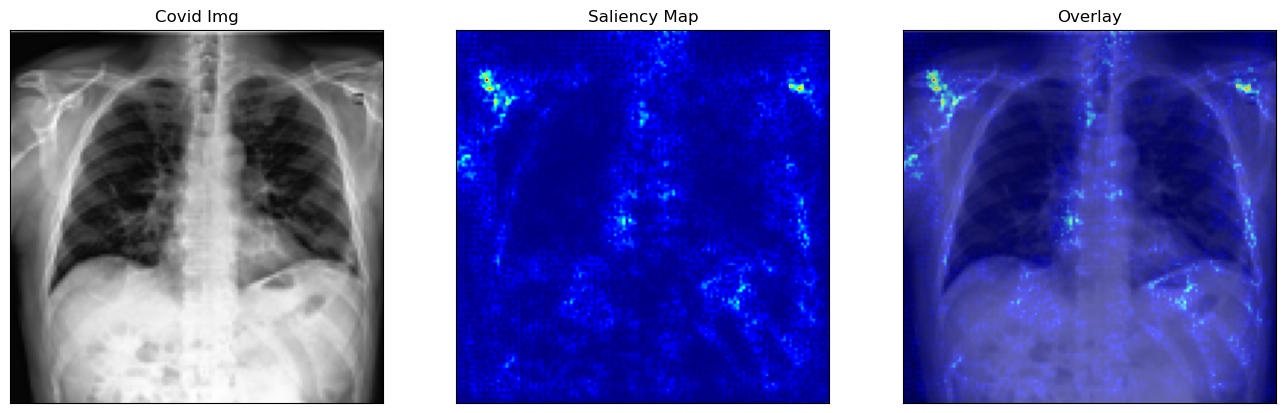

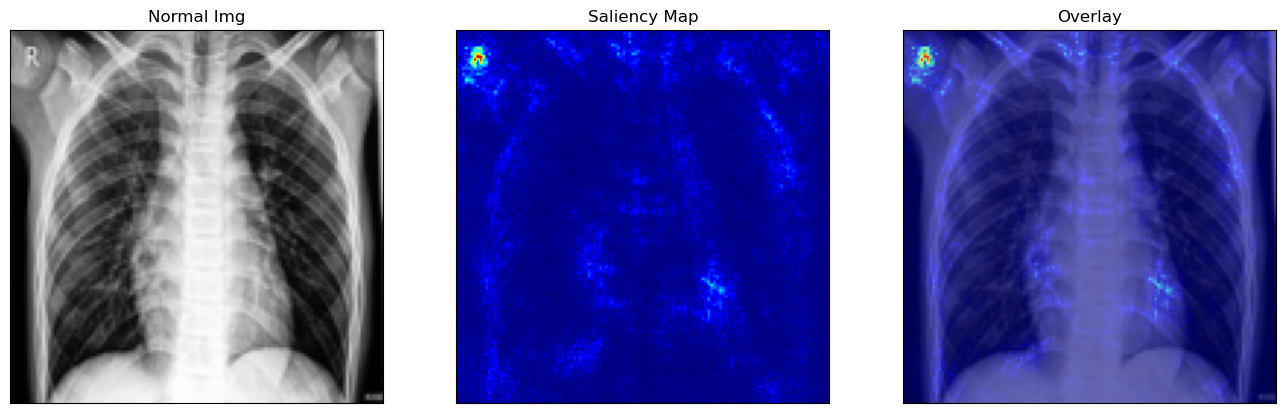

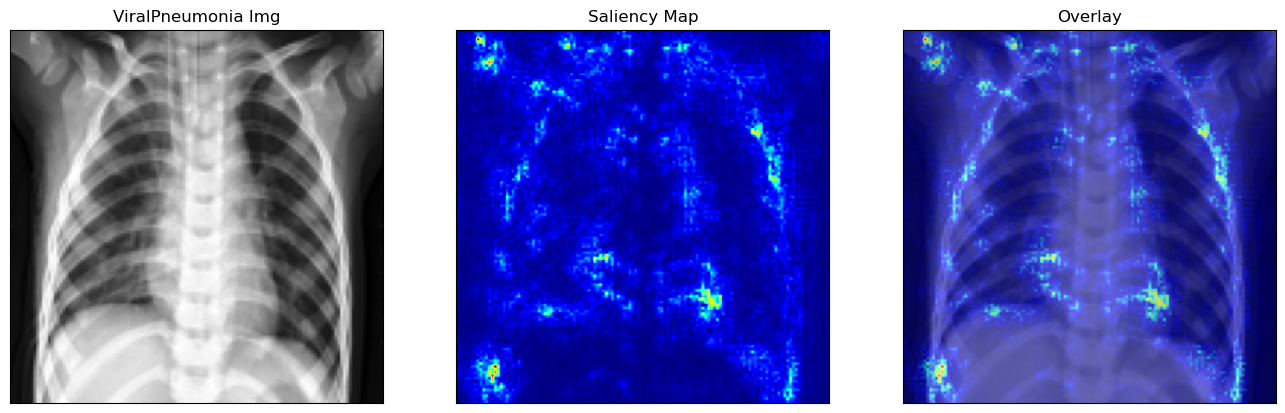

In [8]:
import torch
import torchvision.models as models
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load the pre-trained VGG-19 model

network.eval()

# Freeze the parameters
for param in network.parameters():
    param.requires_grad = False

# Load the image
imgCovid = Image.open('imgCovid.jpeg')
imgNormal = Image.open('imgNormal.jpeg')
imgViralPneumonia = Image.open('imgViralPneumonia.jpeg')

# Preprocess the image
def preprocess(image):
    transform = T.Compose([
        T.Resize((128, 128)),  
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return transform(image).unsqueeze(0)  # Add batch dimension

def deprocess(image):
    transform = T.Compose([
        T.Normalize(mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225], std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
        T.Lambda(lambda x: torch.clamp(x, 0, 1)),  # Clamp to valid range [0, 1]
        T.ToPILImage(),
    ])
    return transform(image)


def visualize_saliency(img, network,img_name):
    # Preprocess the image
    X = preprocess(img)

    # Ensure both model and input image are on the same device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    network.to(device)
    X = X.to(device)
    X.requires_grad_()

    # Forward pass
    scores = network(X)
    score_max_index = scores.argmax()
    score_max = scores[0, score_max_index]
    score_max.backward()

    saliency, _ = torch.max(X.grad.abs(), dim=1)

    # Normalize the saliency map
    saliency = saliency.squeeze().cpu().numpy()
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())

    # Create subplots
    plt.figure(figsize=(18, 12))

    # Visualize the original image, its saliency map, and overlay
    plt.subplot(3, 4, 1)
    plt.imshow(img.resize((128, 128)))
    plt.title(img_name)
    plt.xticks([]), plt.yticks([])

    plt.subplot(3, 4, 2)
    plt.imshow(saliency, cmap=plt.cm.jet)
    plt.title('Saliency Map')
    plt.xticks([]), plt.yticks([])

    plt.subplot(3, 4, 3)
    plt.imshow(img.resize((128, 128)))
    plt.imshow(saliency, cmap=plt.cm.jet, alpha=0.6)
    plt.title('Overlay')
    plt.xticks([]), plt.yticks([])

    plt.tight_layout()
    plt.show()

# Example usage:
visualize_saliency(imgCovid, network,"Covid Img")
visualize_saliency(imgNormal, network,"Normal Img")
visualize_saliency(imgViralPneumonia, network,"ViralPneumonia Img")

In [ ]:
https://discuss.pytorch.org/t/understanding-transform-normalize/21730

https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html

https://www.geeksforgeeks.org/python-loop-through-folders-and-files-in-directory/

https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

https://imgaug.readthedocs.io/en/latest/source/overview/meta.html

https://github.com/sunnynevarekar/pytorch-saliency-maps/blob/master/Saliency_maps_in_pytorch.ipynb